# Prepare modeling data for GIS analyses
The most common way to work with climate modeling data sets is storing them in NetCDF or GRIB format and processing them using Xarray. Raster data sets used in GIS applications are usually stored in raster formats such as GeoTIFF, BIL, or IMG and being processed mainly with the help of GDAL-based python libraries. While modeling data sets are normally georeferenced using grids explicitly described by coordinates and conforming to e.g., CF sandard, geographic reference of GIS data sets is described by a coordinate reference system (CRS). This diferences imply some steps that need to be undertaken in order to convert data sets from one format to another.

In this notebook we create an aggregated map of pre-industrial Vertically Averaged Sea Water Potential Temperature (thetaot) from CMIP6 and save it as GeoTIFF.

First, we import all necessary libraries.

In [1]:
%matplotlib inline
import intake, requests, aiohttp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import cf_xarray as cfxr
import xesmf as xe
# clisops doc: https://clisops.readthedocs.io/en/latest/
from clisops.utils import dataset_utils
import clisops.core as clore

# Rioxarray is an experimental interface between Xarray and Rasterio libraries
# made for loading GDAL-readable rasters as xarray datasets and saving xarrays as raster files.
import rioxarray
#print("Using roocs/clisops in version %s" % cl.__version__)
print("Using xESMF in version %s" % xe.__version__)

xr.set_options(display_style = "html");

import warnings
warnings.simplefilter("ignore") 

Using xESMF in version 0.6.3


## 1. Find and load the data set
Then we find the data set we need in the DKRZ open catalogue and print its metadata.

In [2]:
# Path to master catalog on the DKRZ server
#dkrz_catalog=intake.open_catalog(["https://dkrz.de/s/intake"])
#
#only for the web page we need to take the original link:
dkrz_catalog=intake.open_catalog(["https://gitlab.dkrz.de/data-infrastructure-services/intake-esm/-/raw/master/esm-collections/cloud-access/dkrz_catalog.yaml"])
# Print DKRZ open catalogues
list(dkrz_catalog)

['dkrz_cmip5_archive',
 'dkrz_cmip5_disk',
 'dkrz_cmip6_cloud',
 'dkrz_cmip6_disk',
 'dkrz_cordex_disk',
 'dkrz_dyamond-winter_disk',
 'dkrz_era5_disk',
 'dkrz_nextgems_disk',
 'dkrz_palmod2_disk']

get [thetaot](https://clipc-services.ceda.ac.uk/dreq/u/b5bc9b1fa92a35cec5989eeac3d77d1a.html) data

In [3]:
# Open the catalog with the intake package and name it "col" as short for "collection"

cols=dkrz_catalog._entries["dkrz_cmip6_disk"]._open_args["csv_kwargs"]["usecols"]+["opendap_url"]
col=dkrz_catalog.dkrz_cmip6_disk(csv_kwargs=dict(usecols=cols))
cat = col.search(variable_id = "thetaot",
                 experiment_id = "historical",
                time_range = "185001-194912",
                member_id = "r1i1p1f3"
                )
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,opendap_url,project,format,uri
0,CMIP,MOHC,HadGEM3-GC31-LL,historical,r1i1p1f3,Emon,thetaot,gn,NaN,v20200210,185001-194912,http://esgf3.dkrz.de/thredds/dodsC/cmip6/CMIP/...,CMIP6,netcdf,/work/ik1017/CMIP6/data/CMIP6/CMIP/MOHC/HadGEM...


In [4]:
dset = xr.open_dataset(cat.df.uri.values[0], chunks = {"time": 6})
dset["thetaot"]

<xarray.DataArray 'thetaot' (time: 1200, j: 330, i: 360)>
dask.array<open_dataset-0518e3287998618d27527daf2da4d081thetaot, shape=(1200, 330, 360), dtype=float32, chunksize=(6, 330, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 1949-12-16 00:00:00
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 322 323 324 325 326 327 328 329
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
Attributes:
    standard_name:  sea_water_potential_temperature
    long_name:      Vertically Averaged Sea Water Potential Temperature
    comment:        Vertical average of the sea water potential temperature t...
    units:          degC
    original_name:  mo: level_mean((variable_name: thetao), (variable_name: t...
    cell_methods:   area: depth: time: mean
    cell_measures:  area: areacello

As we can see, coordinates are stored as arrays of grid cell indices, which is not a common format in the GIS community.


## 2. Calculate pre-industrail mean
We make a subset limiting the data set to pre-industrial era, calculate the mean values per grid cell, and plot the result.

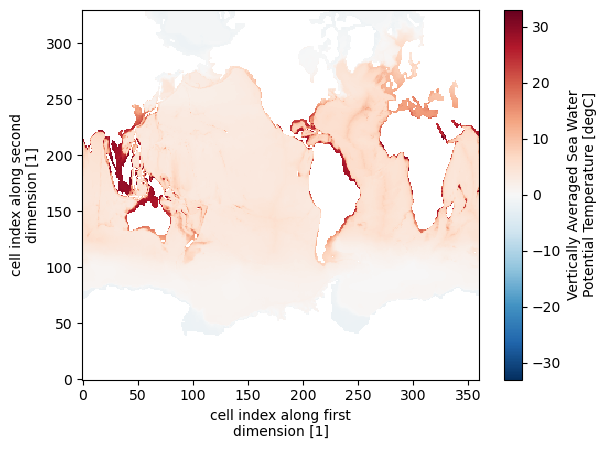

In [5]:
dset["time"] = dset["time"].dt.strftime("%Y%m%d")
pre_industrial = dset["thetaot"].sel(time = slice("1850", "1880"))
pre_industrial_mean = pre_industrial.mean(dim = "time", keep_attrs = True).to_dataset()
pre_industrial_mean.thetaot.plot(); 

This plotted the data along the index dimensions. However, we would like to plot the data with respect to the latitude and longitude coordinates. These are two dimensional coordinate variables for data on a curvilinear grid, and need to be referenced in the plot command:

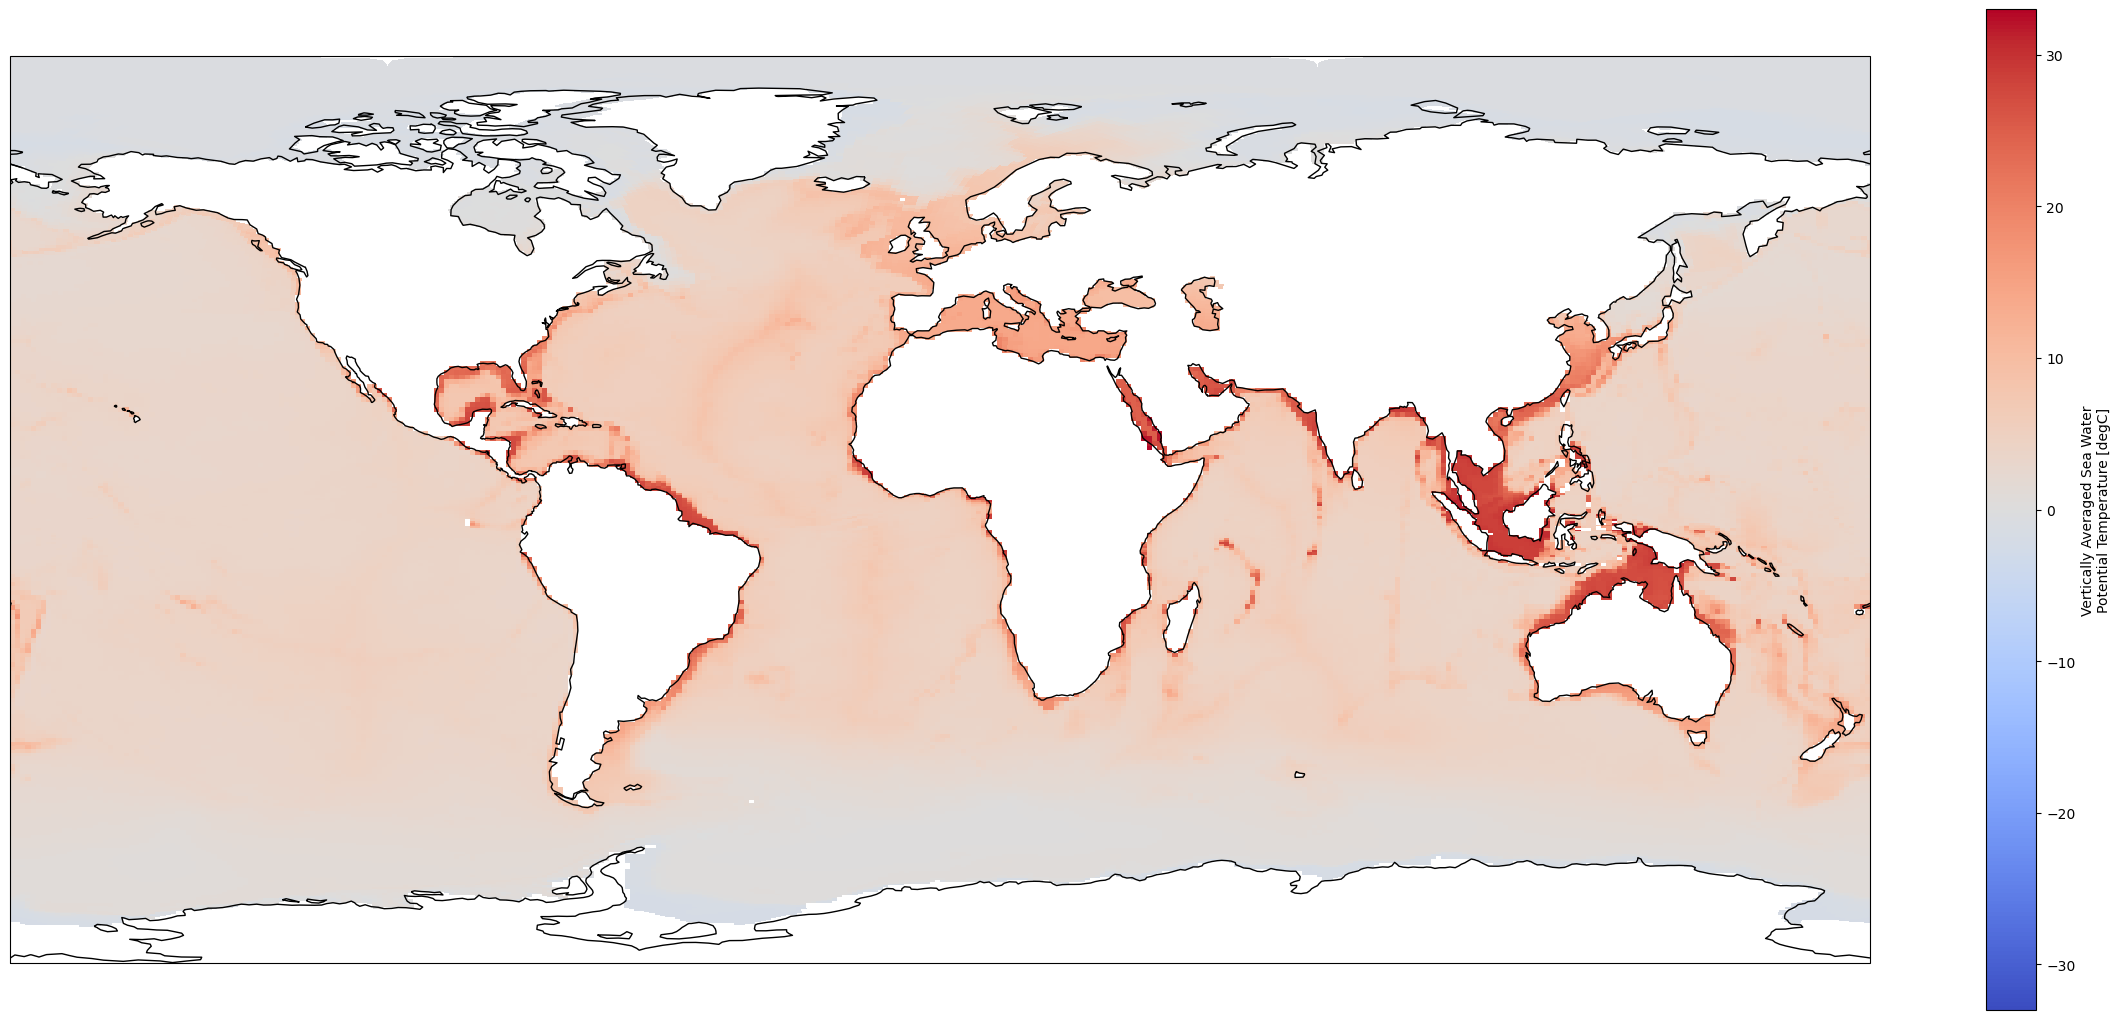

In [6]:
fig = plt.figure(1, figsize = [30, 13])

# Set the projection to use for plotting
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()

# Shift longitude interval from [-180,180] to [0,360] to avoid 
#  shading issues with some cartopy/matplotlib versions
pre_industrial_mean["longitude"] = xr.where(pre_industrial_mean["longitude"]<0.,
                                            pre_industrial_mean["longitude"]+360.,
                                            pre_industrial_mean["longitude"],
                                            keep_attrs=True)
# alternatively use clisops to shift the longitude interval:
#pre_industrial_mean = dataset_utils.cf_convert_between_lon_frames(ds_in=pre_industrial_mean,
#                                                                  lon_interval=(0, 360))[0]

# Pass ax as an argument when plotting. Here we assume data is in the same coordinate reference 
# system than the projection chosen for plotting isel allows to select by indices instead
# of the time values
pre_industrial_mean.thetaot.plot.pcolormesh(ax=ax, x="longitude", y="latitude", 
                                           shading="auto", cmap="coolwarm");

If we visualize our data set's grid, it becomes obvious that it is far from a standard grid.

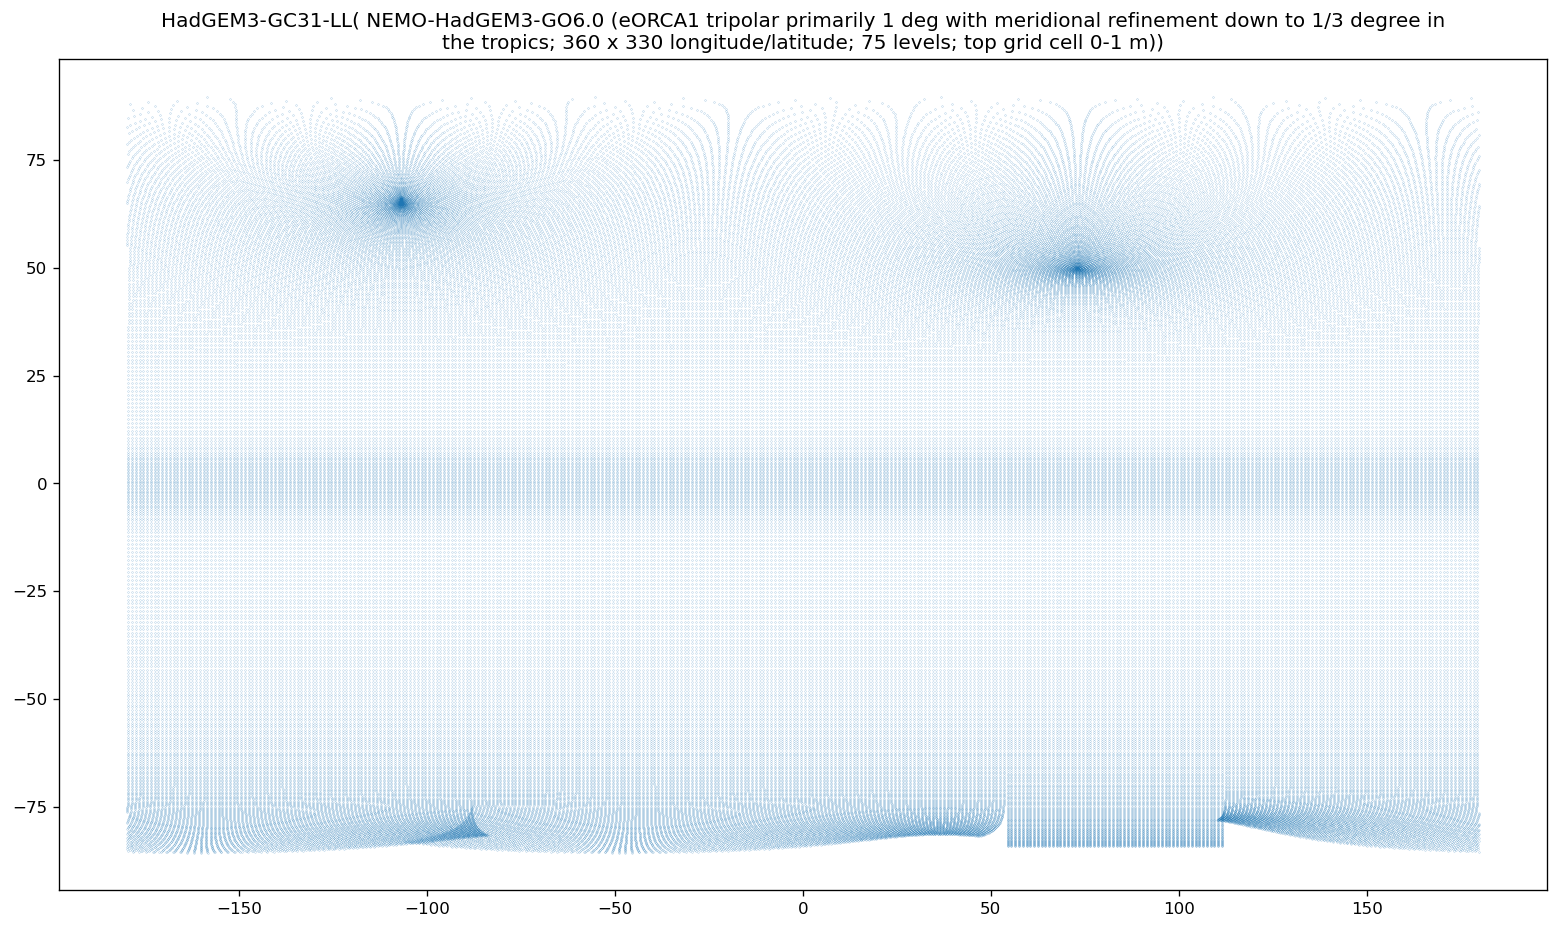

In [7]:
import textwrap
def plot_curv_grid(ds, var = "tos"):    
        lat = cfxr.accessor._get_with_standard_name(ds, "latitude")[0]
        lon = cfxr.accessor._get_with_standard_name(ds, "longitude")[0]        
        if any([i == None for i in [lat, lon]]): 
            print(ds.attrs["source_id"], ": Cannot identify latitude/longitude.")
            return
        plt.figure(figsize = (16, 9), dpi=120)
        plt.scatter(x = ds[lon], y = ds[lat], s = 0.01)
        # x, y = np.meshgrid(ds[lon], ds[lat])
        # plt.scatter(x = x, y = y, s = 0.01)
        try:
            plt.title("\n".join(
                textwrap.wrap(
                    ds.attrs["source_id"] + "(" 
                    + ds.attrs["source"].split("ocean:")[-1].split("\n")[0] + ")", 
                    120)
            ))
        except (KeyError, IndexError):
            plt.title(ds.attrs["source_id"])  
plot_curv_grid(dset)

## 3. Reformat the grid and regrid the data set.
As we mentioned before, the coordinates need to be re-defined.

In [8]:
# Specify a global 1deg target grid

# With clisops
#ds_out = clore.Grid(grid_instructor=(1., )).ds

# Without clisops
ds_out = xe.util.grid_global(1., 1., cf=True)
ds_out

<xarray.Dataset>
Dimensions:             (bound: 2, lon: 360, lat: 180)
Coordinates:
  * lon                 (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat                 (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    latitude_longitude  float64 nan
Dimensions without coordinates: bound
Data variables:
    lon_bounds          (bound, lon) float64 -180.0 -179.0 ... 179.0 180.0
    lat_bounds          (bound, lat) float64 -90.0 -89.0 -88.0 ... 89.0 90.0

And now we regrid the data set to a normal 1-degree global grid.

In [9]:
# In case of problems, activate ESMF verbose mode
import ESMF
ESMF.Manager(debug = True)

# Regridding methods
#method_list = ["bilinear", "nearest_s2d", "patch", "conservative"]

# Function to generate the weights
#   If grids have problems of degenerated cells near the poles there is the ignore_degenerate option
def regrid(ds_in, ds_out, method, periodic, unmapped_to_nan = True, ignore_degenerate = None):
    """Convenience function for calculating regridding weights"""
    return xe.Regridder(ds_in, ds_out, method, periodic = periodic, 
                        ignore_degenerate = ignore_degenerate) 

In [10]:
%time regridder = regrid(pre_industrial_mean, \
                         ds_out, \
                         method="bilinear", \
                         periodic=True, \
                         unmapped_to_nan=True, \
                         ignore_degenerate=None)

CPU times: user 3.59 s, sys: 5.05 ms, total: 3.59 s
Wall time: 3.6 s


In [11]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_330x360_180x360_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (330, 360) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

In [12]:
regridded_ds = regridder(pre_industrial_mean, keep_attrs=True)
regridded_ds

<xarray.Dataset>
Dimensions:             (lat: 180, lon: 360)
Coordinates:
    latitude_longitude  float64 nan
  * lon                 (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat                 (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    thetaot             (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

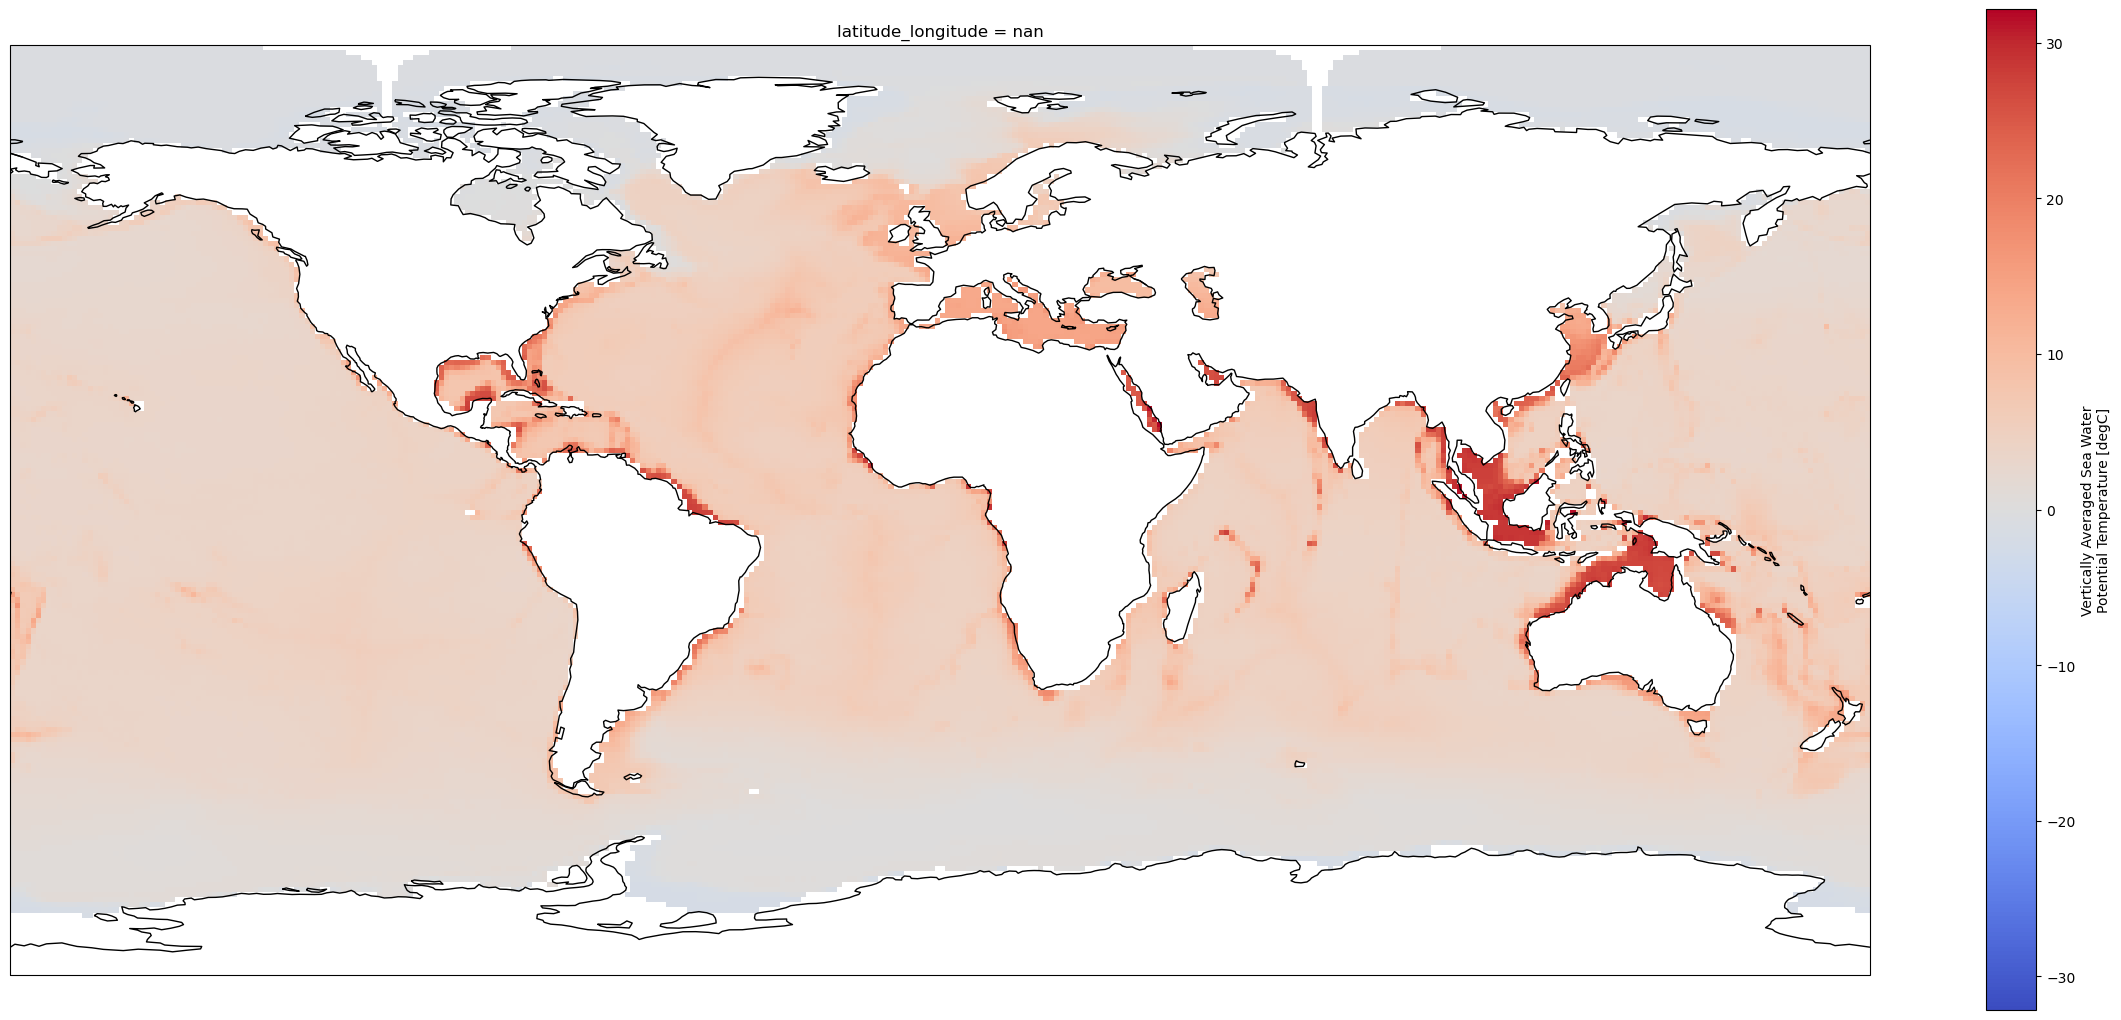

In [13]:
fig = plt.figure(1, figsize = [30, 13])

# Set the projection to use for plotting
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()

# Pass ax as an argument when plotting. Here we assume data is in the
# same coordinate reference system than the projection chosen for plotting
# isel allows to select by indices instead of the time values
regridded_ds.thetaot.plot.pcolormesh(ax=ax, cmap="coolwarm");

As we can see, data on a regular latitude longitude grid is plotted properly
without further specifications.

## 4. Write a CRS and save the data set as a GeoTIFF
It is pretty straitforward to write a CRS to an xarray with rioxarray. Here we used the World Geodetic System 1984 CRS which is quite common and used by default, for example in QGIS.

In [14]:
#You might need to rename the axes before
transformed = regridded_ds.rename({"lon":"x", "lat":"y"})

transformed = transformed.rio.write_crs("EPSG:4326")

If we want to re-project the data set to e.g., Web Mercator, wich is used by default in Google Maps and ArcGIS, we do it as follows:

In [15]:
transformed = transformed.rio.reproject("EPSG:3857")

And finally, saving our dataset as a GeoTIFF is as easy as this:

In [18]:
transformed.rio.to_raster("regridded_3857.tif")

# what to do with the saved GeoTIFF ???

In [5]:
from osgeo import gdal
import matplotlib.pyplot as plt
   
dataset = gdal.Open(r'regridded_3857.tif')

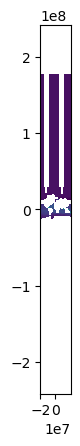

<AxesSubplot:>

In [4]:
import rasterio
from rasterio.plot import show
fp = r'regridded_3857.tif'
img = rasterio.open(fp)
show(img)